In [1]:
import cv2 
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calc_hog(img):
    img = cv2.resize(img,(50,50))
    win_size = (20,20)
    block_size = (10,10)
    block_stride = (5,5)
    cell_size = (5,5)
    nbins = 9
    descriptor = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    hog_vec_img = descriptor.compute(img)
    return hog_vec_img.T

In [3]:
N_FEATURES = 15876

In [4]:
### CREATE X_train, y_train

train_hd_files = glob.glob("../opencv-np-workshop/data/hotdog/train/hot_dog/*")
train_nhd_files = glob.glob("../opencv-np-workshop/data/hotdog/train/not_hot_dog/*")

train_size = len(train_hd_files)+len(train_nhd_files)
X_train = np.zeros((train_size, N_FEATURES))
y_train = np.zeros((train_size, 1))

# Initialize arrays of right size
X_train = np.zeros((train_size, N_FEATURES))
y_train = np.zeros((train_size, 1))

# Populate arrays
for i, f in enumerate(train_hd_files):
    img = cv2.imread(f)
    feat = calc_hog(img)
    X_train[i,:] = feat
    y_train[i] = 1
    
for i, f in enumerate(train_nhd_files):
    img = cv2.imread(f)
    feat = calc_hog(img)
    X_train[i+len(train_hd_files),:] = feat
    
# Convert to np.float32/np.int32 before going to OpenCV
X_train = np.ndarray.astype(X_train, dtype=np.float32)
y_train = np.ndarray.astype(y_train, dtype=np.int32)

In [5]:
### CREATE X_train, y_train

test_hd_files = glob.glob("../opencv-np-workshop/data/hotdog/test/hot_dog/*")
test_nhd_files = glob.glob("../opencv-np-workshop/data/hotdog/test/not_hot_dog/*")

test_size = len(test_hd_files)+len(test_nhd_files)
X_test = np.zeros((test_size, N_FEATURES))
y_test = np.zeros((test_size, 1))

# Initialize arrays of right size
X_test = np.zeros((test_size, N_FEATURES))
y_test = np.zeros((test_size, 1))

# Populate arrays
for i, f in enumerate(test_hd_files):
    img = cv2.imread(f)
    feat = calc_hog(img)
    X_test[i,:] = feat
    y_test[i] = 1
    
for i, f in enumerate(test_nhd_files):
    img = cv2.imread(f)
    feat = calc_hog(img)
    X_test[i+len(test_hd_files),:] = feat
    
# Convert to np.float32/np.int32 before going to OpenCV
X_test = np.ndarray.astype(X_test, dtype=np.float32)
y_test = np.ndarray.astype(y_test, dtype=np.int32)

In [6]:
X_train.shape

(498, 15876)

In [7]:
X_test.shape

(500, 15876)

In [8]:
y_train.shape

(498, 1)

In [9]:
y_test.shape

(500, 1)

# Hyperparameter selection

- Use the error plots to choose a good hyperparameter

## k-NN: k-Nearest Neighbours

- Hyperparameter $k$.
- For every training example, it looks at the distance between all the points.
- The label or class of each point is obtained as the vote of the $k$ closest points.
- **Lazy learner**: No coefficients/weights are estimated on training. It only stores a copy of the features and labels of the train set and of $k$. This information is used to estimate the class of those points outside of the train set. 

#### Train k-NN

In [10]:
k = 3
knn = cv2.ml.KNearest_create()

In [11]:
knn.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

#### Measure error on the test set

In [12]:
y_pred = knn.findNearest(X_test, k)[1]

In [13]:
avg_error = (y_test != y_pred).mean() # average error on the test set
accuracy = (y_test == y_pred).mean() # average accuracy on the test set

In [14]:
avg_error

0.284

In [15]:
accuracy

0.716

In [16]:
y_pred.shape

(500, 1)

In [17]:
accuracies = []
ks = []
for k in range(3,10):
    y_pred = knn.findNearest(X_test, k)[1]
    accuracy = (y_test == y_pred).mean()
    ks.append(k)
    accuracies.append(accuracy)



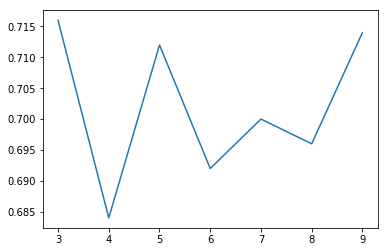

In [18]:
plt.plot(ks, accuracies)

### Do we need more data or better model?

- Choose a random sample of the data (for train and for test).
- Plot on the $x-$axis the sample size.
- On the $y-$axis we look at the error on the train set and on the same chart also the error on the test set.

##### What for?

- **Low gap between train and test, high accuracy:** Ideal case, no need for tuning/add data.
- **High gap, high accuracy:** Train data data is not representative of the world ==> add data.
- **Low gap, low accuracy:** We have a bias problem, our data is ok. We need to change hyperparameters or algorithm.
- **High gap, low accuracy:** Bad situation, both data and hyperparameters need to be fixed.


In [19]:
sample_sizes = range(10,240,20)

In [20]:
n_samples = []
train_acc = []
test_acc = []

In [21]:
def eval_sample_clf(X_train, X_test, y_train, y_test, s):
    knn = cv2.ml.KNearest_create()
    
    idxs = np.random.choice(range(248), s) # Chooses s random indices
    X_train_sample = np.copy(X_train[idxs,:])
    y_train_sample = np.copy(y_train[idxs])
    
    idxs = np.random.choice(range(248), s) # Chooses s random indices
    X_test_sample  = np.copy(X_test[idxs,:])
    y_test_sample = np.copy(y_test[idxs])
    
    # Train knn
    knn.train(X_train_sample, cv2.ml.ROW_SAMPLE, y_train_sample)

    # Calculate train accuracy
    y_train_pred = knn.findNearest(X_train_sample, 3)[1]
    acc_train = (y_train_sample == y_train_pred).mean()
    
    #Calculate test accuracy
    y_test_pred = knn.findNearest(X_test_sample, 3)[1]
    acc_test = (y_test_sample == y_test_pred).mean()

    return acc_train, acc_test
    
    

In [22]:
for s in sample_sizes:
    acc_train, acc_test = eval_sample_clf(X_train, X_test, y_train, y_test, s)
    
    # store
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    
    # Add sample size
    n_samples.append(s)

In [23]:
acc_train

1.0

In [24]:
acc_test

1.0

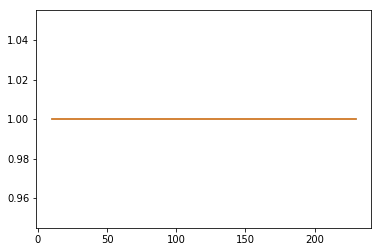

In [25]:
plt.plot(n_samples, train_acc)
plt.plot(n_samples, test_acc)
plt.show()

In [26]:
y_test_pred.shape

NameError: name 'y_test_pred' is not defined